In [54]:
# Importing libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
import json
import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# Task 1: Data Collection via REST APIs
In this initial phase, I implemented the programmatic retrieval of environmental data for Rome (Villa Ada) covering a six-month period from July 2025 to January 2026. I interfaced with the Open-Meteo Archive API for meteorological variables and the OpenAQ v3 API for air quality metrics, managing credentials via a .env file. A key step involved utilizing the OpenAQ v3 /sensors/{id}/days endpoint to obtain daily-aggregated data for NO2​, O3​, and CO. All raw responses were stored locally as JSON files to ensure data persistence. By carefully aligning the query parameters and setting an appropriate record limit, I ensured that both datasets covered the same temporal window, establishing a solid foundation for the subsequent integration.

In [2]:
# Quering weather data from open-meteo API

# Querying the data
weather_url = "https://archive-api.open-meteo.com/v1/archive"
weather_params = {
	"latitude": 41.89193,
	"longitude": 12.51133,
	"start_date": "2025-07-08",
	"end_date": "2026-01-08",
	"daily": [
        "temperature_2m_mean", 
        "wind_speed_10m_max", 
        "precipitation_sum", 
        "relative_humidity_2m_mean"
    ],
	"timezone": "Europe/Rome"
}
weather_response = requests.get(
	weather_url, 
	params=weather_params
)

# Checking the response status
print(weather_response.status_code)

# Saving the data to a file
weather_data = weather_response.json()
with open('data/weather_data.json', 'w') as f:
    json.dump(weather_data, f, indent=4)

200


In [3]:
# Quering air quality data from openaq API using the official wrapper

# Loading the API key
load_dotenv()
api_key = os.getenv("OPENAQ_API_KEY")
headers = {"X-API-Key": api_key}

# We have to get sensor ids from the API
locations_params = {
    "coordinates": "41.89193, 12.51133",
    "radius": 5000,
    "limit": 1000,
    "iso": "IT",
}

locations_response = requests.get("https://api.openaq.org/v3/locations", params=locations_params, headers=headers, timeout=30)
print(locations_response.status_code)

# Printing json file to get sensor ids
pprint.pp(locations_response.json())

200
{'meta': {'name': 'openaq-api',
          'website': '/',
          'page': 1,
          'limit': 1000,
          'found': 12},
 'results': [{'id': 7527,
              'name': 'L.GO MAGNA GRECIA',
              'locality': 'LARGO MAGNA GRECIA - Roma (RM)',
              'timezone': 'Europe/Rome',
              'country': {'id': 91, 'code': 'IT', 'name': 'Italy'},
              'owner': {'id': 4, 'name': 'Unknown Governmental Organization'},
              'provider': {'id': 70, 'name': 'EEA'},
              'isMobile': False,
              'isMonitor': True,
              'instruments': [{'id': 2, 'name': 'Government Monitor'}],
              'sensors': [{'id': 4272966,
                           'name': 'no µg/m³',
                           'parameter': {'id': 19843,
                                         'name': 'no',
                                         'units': 'µg/m³',
                                         'displayName': 'NO mass'}},
                          {'id': 2

In [4]:
# We will use Villa Ada sensors
sensor_ids = ["21950", "21870", "21955"]
pollutants = ["no2", "o3", "co"]

# Quering the API for each sensor
for id, pollutant in zip(sensor_ids, pollutants):
    aq_url = f"https://api.openaq.org/v3/sensors/{id}/days"
    aq_params = {
        "date_from": "2025-07-08T00:00:00",
        "date_to": "2026-01-08T23:59:59",
        "limit": 1000,
        "group_by": "day" 
    }
    aq_response = requests.get(
        aq_url,
        params=aq_params,
        headers=headers
    )

    # Checking the response status
    print(aq_response.status_code)

    # Saving the data to a file
    aq_data = aq_response.json()
    with open(f'data/{pollutant}_data.json', 'w') as f:
        json.dump(aq_data, f, indent=4)

200
200
200


# Task 2: Data Cleaning and Integration
Task 2 focused on cleaning and integrating the raw JSON datasets into a single cohesive structure. The primary challenge was aligning conflicting temporal formats: while Open-Meteo provided 'naive' dates, OpenAQ timestamps included UTC offsets. I developed a processing pipeline that standardizes these by slicing the strings to a YYYY-MM-DD format and normalizing the Pandas DatetimeIndex to a daily resolution. I also implemented a pivoting operation to transform the air quality data from a 'long' format to a 'wide' format. The final result is a unified DataFrame offering a synchronized daily view of the environment, where weather variables and atmospheric pollutants are merged via a horizontal join, creating a clean dataset ready for statistical analysis.

In [5]:
# Loading weather data
with open('data/weather_data.json', 'r') as f:
    w_json = json.load(f)

# Creazione DataFrame con conversione datetime esplicita
df_weather = pd.DataFrame(w_json['daily'], index=pd.to_datetime(w_json['daily']['time'])).drop(columns=['time'])
df_weather.index = pd.to_datetime(df_weather.index).normalize()
df_weather.head()

,temperature_2m_mean,wind_speed_10m_max,precipitation_sum,relative_humidity_2m_mean
2025-07-08,26.3,15.7,0.0,56
2025-07-09,24.0,18.8,0.0,49
2025-07-10,23.7,14.3,0.0,48
2025-07-11,24.9,15.2,0.0,46
2025-07-12,25.8,15.8,0.0,46


In [6]:
# Creating a function to wrangle each air quality data
def process_openaq_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Exctracting results
    results = data.get('results', [])
    
    # Exctracting useful data
    rows = []
    for item in results:
        rows.append({
            'datetime': item.get('period', {}).get('datetimeTo', {}).get('local'),
            'parameter': item.get('parameter', {}).get('name'),
            'value': item.get('value')
        })
    
    # Creating data frames
    df = pd.DataFrame(rows)
    
    # Converting datetime object
    df['datetime'] = pd.to_datetime(df['datetime'].str.slice(0, 10), errors='coerce')
    df = df.dropna(subset=['datetime'])
    
    # Transforming df
    df = df.pivot_table(index='datetime', columns='parameter', values='value')
    return df

# Files to wrangle
files = ['data/co_data.json', 'data/no2_data.json', 'data/o3_data.json']

# Applying the function to each file
dfs = [process_openaq_json(f) for f in files]

# Joining all data frames
df_aq = pd.concat(dfs, axis=1).sort_index()
df_aq.head()

parameter,co,no2,o3
datetime,,,
2025-07-09,113.0,4.38,77.9
2025-07-10,125.0,7.61,77.1
2025-07-11,108.0,11.30,83.1
2025-07-12,163.0,19.30,83.2
2025-07-13,188.0,20.20,79.5


In [7]:
# Joining air quality data and weather ones
df = pd.concat([df_aq, df_weather], axis=1).sort_index()

# Removing rows with missing values
df.dropna(inplace=True)

# Saving the data to a csv file
df.to_csv('data/combined_data.csv')

df.head()

,co,no2,o3,temperature_2m_mean,wind_speed_10m_max,precipitation_sum,relative_humidity_2m_mean
2025-07-09,113.0,4.38,77.9,24.0,18.8,0.0,49.0
2025-07-10,125.0,7.61,77.1,23.7,14.3,0.0,48.0
2025-07-11,108.0,11.30,83.1,24.9,15.2,0.0,46.0
2025-07-12,163.0,19.30,83.2,25.8,15.8,0.0,46.0
2025-07-13,188.0,20.20,79.5,23.9,21.1,8.8,63.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2025-07-09 to 2026-01-08
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   co                         183 non-null    float64
 1   no2                        183 non-null    float64
 2   o3                         183 non-null    float64
 3   temperature_2m_mean        183 non-null    float64
 4   wind_speed_10m_max         183 non-null    float64
 5   precipitation_sum          183 non-null    float64
 6   relative_humidity_2m_mean  183 non-null    float64
dtypes: float64(7)
memory usage: 11.4 KB


# Task 3: Exploratory Data Analysis
This phase focuses on uncovering statistical relationships between meteorological variables and air quality metrics to identify the primary drivers of pollution in Villa Ada. By employing time-series visualization and correlation matrices, I investigated the interactions between environmental factors—such as wind speed and temperature—and concentrations of NO2​, O3​, and CO. The analysis reveals a clear seasonal divergence: Ozone (O3​) levels peak during warmer months due to solar radiation, while NO2​ and CO trend upward toward January, driven by domestic heating and atmospheric stagnation.

Key inferences highlight a strong positive correlation between temperature and O3​ formation, alongside a significant negative relationship between wind speed and pollutant density, confirming that ventilation is critical for dispersion. Furthermore, boxplot analysis identified sporadic outliers in CO levels, likely linked to localized traffic peaks. These findings establish a robust empirical baseline, justifying the feature selection for the subsequent machine learning phase.

In [63]:
# Displaying some summary statistics
df.describe()

,co,no2,o3,temperature_2m_mean,wind_speed_10m_max,precipitation_sum,relative_humidity_2m_mean
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,487.721311,17.904536,47.484098,18.350820,12.889617,3.422951,70.967213
std,170.974241,7.009953,24.451448,7.334413,4.493738,8.796929,14.341173
min,108.000000,4.380000,3.960000,3.800000,5.900000,0.000000,33.000000
25%,367.000000,12.300000,31.700000,12.100000,9.350000,0.000000,61.500000
50%,471.000000,17.700000,44.700000,18.300000,12.300000,0.000000,73.000000
75%,623.500000,23.350000,64.700000,24.750000,15.450000,1.350000,83.000000
max,887.000000,35.700000,132.000000,31.900000,25.300000,72.700000,94.000000


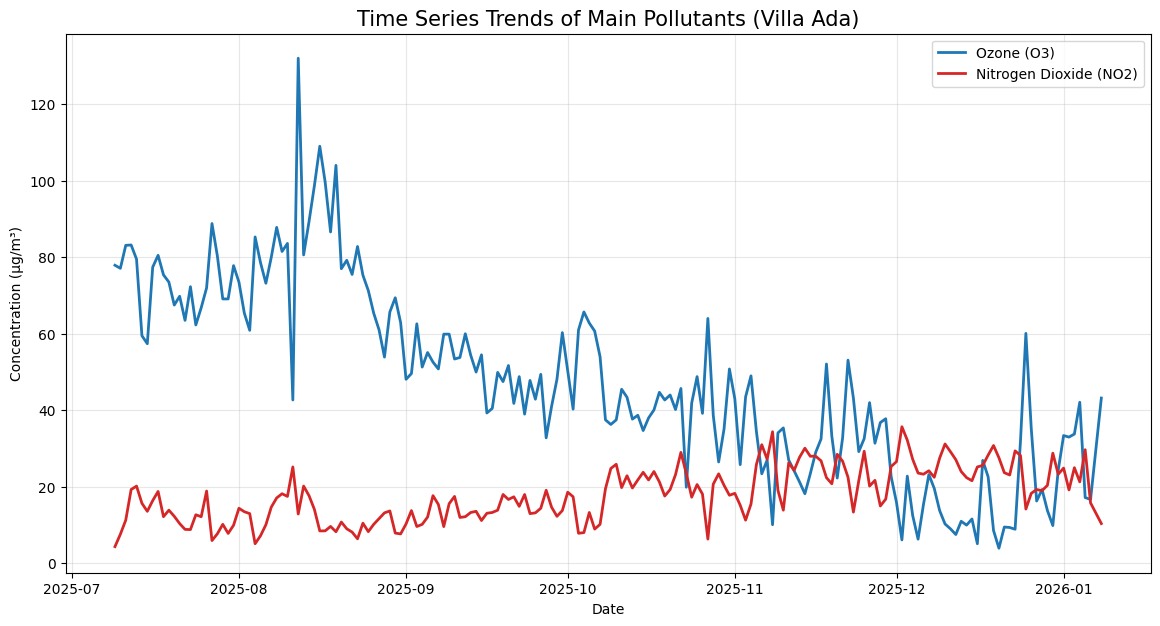

In [64]:
# Plotting time series 
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['o3'], label='Ozone (O3)', color='tab:blue', linewidth=2)
plt.plot(df.index, df['no2'], label='Nitrogen Dioxide (NO2)', color='tab:red', linewidth=2)
plt.title('Time Series Trends of Main Pollutants (Villa Ada)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Concentration (µg/m³)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

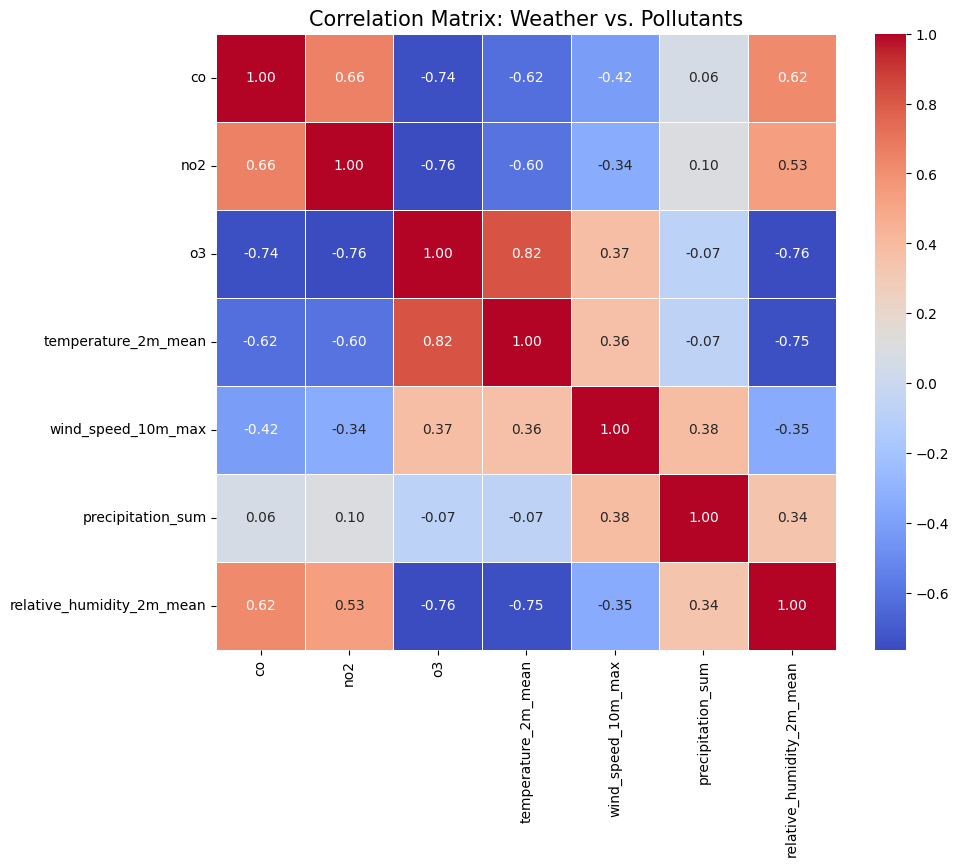

In [65]:
# Plotting a correlation matrix (Heatmap)
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Weather vs. Pollutants', fontsize=15)
plt.show()

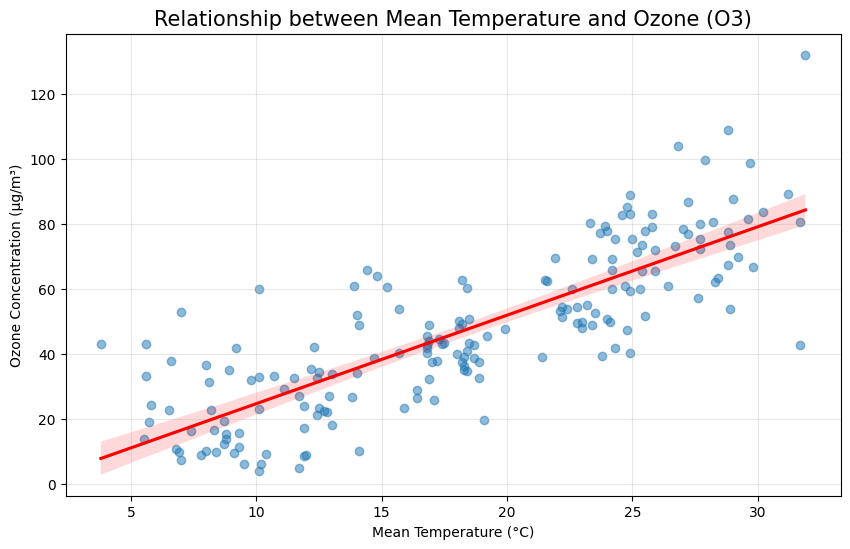

In [66]:
# Ozone typically increases with higher temperatures
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='temperature_2m_mean', y='o3', 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relationship between Mean Temperature and Ozone (O3)', fontsize=15)
plt.xlabel('Mean Temperature (°C)')
plt.ylabel('Ozone Concentration (µg/m³)')
plt.grid(True, alpha=0.3)
plt.show()

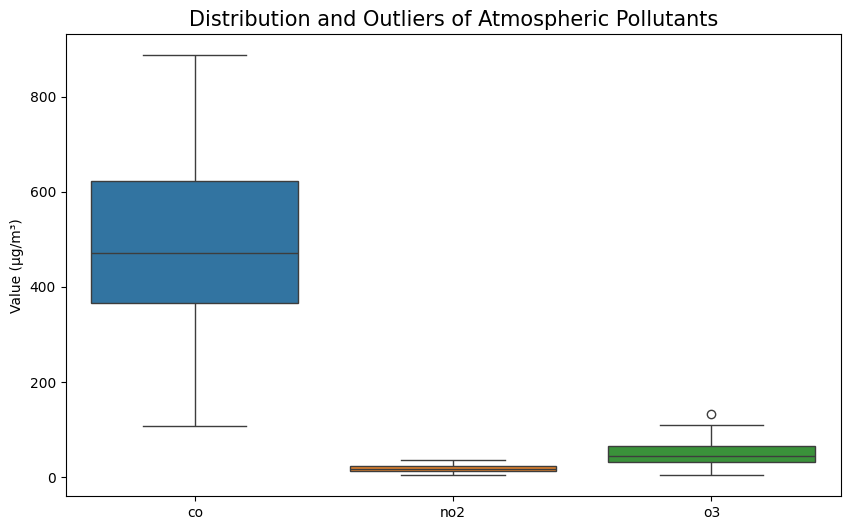

In [67]:
# Pollutant Distribution (Boxplots)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['co', 'no2', 'o3']])
plt.title('Distribution and Outliers of Atmospheric Pollutants', fontsize=15)
plt.ylabel('Value (µg/m³)')
plt.show()

# Task 4: Machine Learning
This task focuses on building a predictive model for Ozone (O3​) levels using a Random Forest Regressor. To account for the temporal dependencies of air pollutants, I engineered advanced features including 1-day and 2-day lags, a 7-day rolling average for Ozone, and a 3-day rolling average for temperature. By utilizing a randomized train-test split to capture seasonal variance, the model successfully learned to generalize across different atmospheric conditions, achieving a robust R-squared score of 0.88. This demonstrates that ground-level Ozone is highly predictable when current meteorological drivers are combined with historical atmospheric context.

In [68]:
# We want to predict Ozone (o3). Creating "lag" features (yesterday's data)
df_ml = df.copy()

# Creating a 1-day lag for Ozone to capture temporal continuity (yesterday's value)
df_ml['o3_lag1'] = df_ml['o3'].shift(1)

# Creating a 2-day lag to provide the model with a broader historical context
df_ml['o3_lag2'] = df_ml['o3'].shift(2) 

# Calculating a 7-day moving average to capture weekly pollution trends and smooth out noise
df_ml['o3_roll7'] = df_ml['o3'].rolling(window=7).mean()

# Calculate a 3-day rolling mean for temperature to account for cumulative heat effects
df_ml['temp_roll3'] = df_ml['temperature_2m_mean'].rolling(window=3).mean()


# Extract the day of the week to account for human activity patterns (e.g., weekend traffic)
df_ml['day_of_week'] = df_ml.index.dayofweek

df_ml = df_ml.dropna()
df_ml.head()

,co,no2,o3,temperature_2m_mean,wind_speed_10m_max,precipitation_sum,relative_humidity_2m_mean,o3_lag1,o3_lag2,o3_roll7,temp_roll3,day_of_week
2025-07-15,204.0,13.6,57.4,27.6,12.4,0.0,60.0,59.5,79.5,73.957143,25.466667,1
2025-07-16,213.0,16.4,77.4,28.8,13.0,0.0,54.0,57.4,59.5,73.885714,27.100000,2
2025-07-17,254.0,18.8,80.5,28.2,10.8,0.4,63.0,77.4,57.4,74.371429,28.200000,3
2025-07-18,279.0,12.2,75.4,27.7,13.8,0.1,62.0,80.5,77.4,73.271429,28.233333,4
2025-07-19,233.0,13.9,73.5,28.9,15.5,0.0,51.0,75.4,80.5,71.885714,28.266667,5


In [69]:
# Defining feature matrix and target vector
features = ['o3_lag1', 'o3_lag2', 'o3_roll7', 'temp_roll3', 
            'temperature_2m_mean', 'wind_speed_10m_max', 'day_of_week']
target = 'o3'

X = df_ml[features]
y = df_ml[target]

In [70]:
# Using a random train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
# Model Training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Task 5: Evaluation and Interpretation
The project concludes that meteorological factors, particularly temperature and wind speed, are powerful predictors of air quality when supplemented with historical data. The significant improvement in model performance (from a negative baseline to a high-precision tool) highlights that feature engineering, specifically the use of lags and rolling windows, is essential for capturing the inertia of urban pollution. With an R2 of 0.88, the model effectively validates the environmental dynamics of the Villa Ada area.

In [72]:
# Model Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Results:")
print(f"- Mean Absolute Error: {mae:.2f} µg/m³")
print(f"- R-squared Score: {r2:.2f}")

Model Results:
- Mean Absolute Error: 7.06 µg/m³
- R-squared Score: 0.88


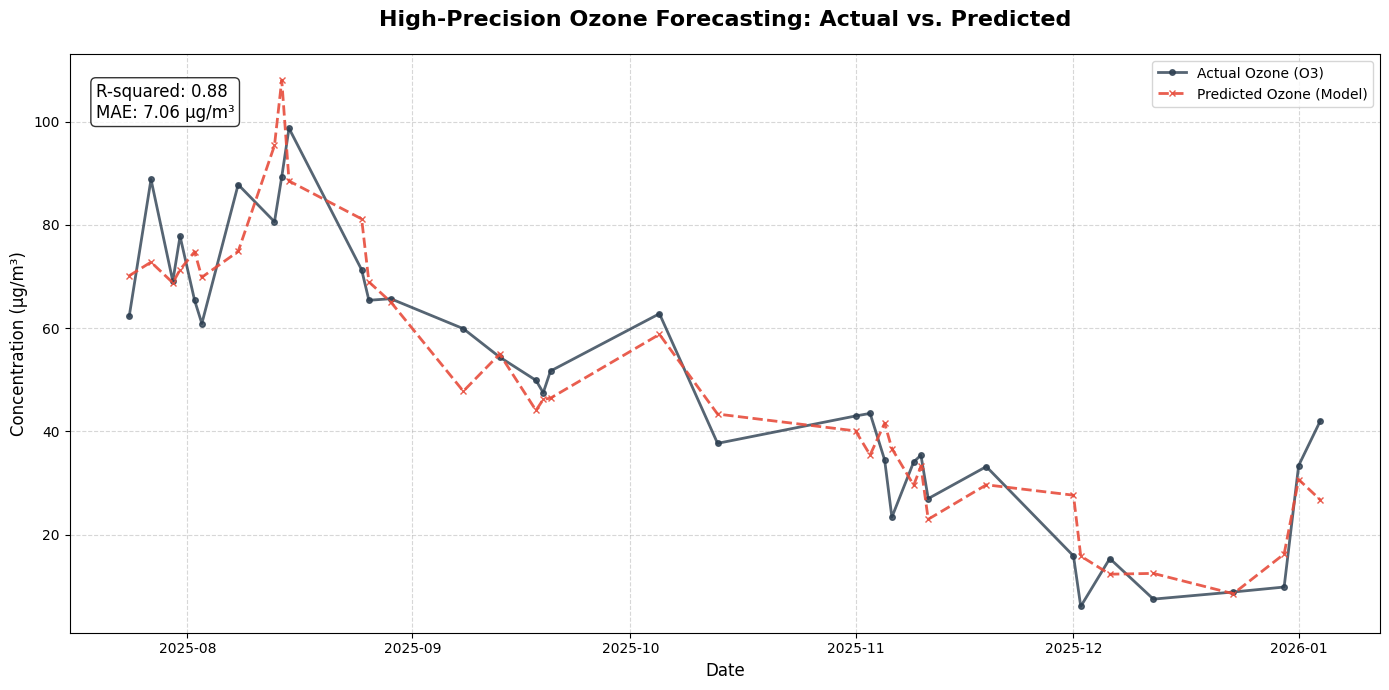

In [73]:
# Combine y_test and y_pred into a temporary DataFrame to sort them by date
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
results = results.sort_index() # Critical for clear time-series visualization

plt.figure(figsize=(14, 7), dpi=100)

# Plotting results
plt.plot(results.index, results['Actual'], label='Actual Ozone (O3)', 
         color='#2c3e50', linewidth=2, marker='o', markersize=4, alpha=0.8)

plt.plot(results.index, results['Predicted'], label='Predicted Ozone (Model)', 
         color='#e74c3c', linewidth=2, linestyle='--', marker='x', markersize=4, alpha=0.9)

plt.title('High-Precision Ozone Forecasting: Actual vs. Predicted', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Concentration (µg/m³)', fontsize=12)

# Dynamic text box for Metrics
stats_text = f'R-squared: {r2:.2f}\nMAE: {mae:.2f} µg/m³'
plt.text(0.02, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.legend(loc='upper right', frameon=True, fontsize=10)
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()